# EFD latency characterization

This notebook shows how to get data from the InfluxDB API to characterize the total latency for a message from the time it is sent by SAL to the time it is written to InfluxDB.

In [5]:
%%capture packages
import sys
!{sys.executable} -m pip install matplotlib
!{sys.executable} -m pip install pandas
!{sys.executable} -m pip install requests

In [6]:
import requests
import matplotlib.pyplot as plt
import pandas as pd

## InfluxDB URL and database to read from

In [7]:
INFLUXDB_API_URL = "https://influxdb-summit-efd.lsst.codes"
INFLUXDB_DATABASE = "efd"

In [9]:
import getpass
USERNAME = "saluser"
PASSWORD = getpass.getpass(prompt='Password for user `{}`: '.format(USERNAME))

Password for user `saluser`: ········


## Retrieving timestamps for a given topic
The following timestamps are available (the order reflects the actual message flow through the system) 

- **private_sndStamp**: Timestamp in seconds added by SAL when the message was created
- **private_kafkaStamp**: Timestamp in seconds added by the SAL Kafka Producer right before it is sent to the EFD
- **time**: Timestamp in millisecons when the message is written to InfluxDB.


In [40]:
def get_timestamps(topic, past='1h'):
    
    query = 'SELECT "private_sndStamp" FROM "{}\"."autogen"."{}" where time > now()-{}'
    params={'q': query.format(INFLUXDB_DATABASE, topic, past), 'epoch': 'ms', 'chunked': '200000', 'u': USERNAME, 'p': PASSWORD}
    
    r = requests.post(url=INFLUXDB_API_URL + "/query", params=params)
    
    return r.json()

In [41]:
data = get_timestamps("lsst.sal.MTM1M3.forceActuatorData")['results'][0]['series'][0]
df = pd.DataFrame.from_records(data['values'], columns=data['columns'])
df.head()

,time,private_sndStamp
0,1582734289611,1.582734e+09
1,1582734289709,1.582734e+09
2,1582734289810,1.582734e+09
3,1582734289910,1.582734e+09
4,1582734290009,1.582734e+09


## Latency and time in seconds

In [45]:
df['latency'] = (df['time'] - df['private_sndStamp']*1000)/1000
df['time_seconds'] = (df['time']-df['time'][0])/1000

## Latency characterization

In [46]:
median = df.latency.median()
quantile99 = df.latency.quantile(.99)

Text(50, 21.30944091796875, 'Median=0.0232s 99% percentile=13.12s')

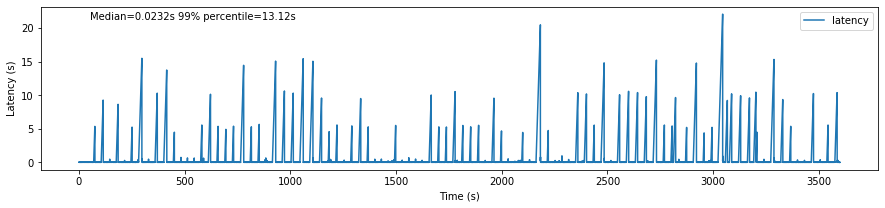

In [47]:
p = df.plot(x='time_seconds', y='latency', figsize=(15,3))
p.set_xlabel("Time (s)")
p.set_ylabel("Latency (s)")
p.text(50,df.latency.max()-0.75,"Median={:.4f}s 99% percentile={:.2f}s".format(median, quantile99))